# Evaluation of trained models

## Imports

In [24]:
import pandas as pd

from eval_lib import load_model
from models import Transformer
from matplotlib import pyplot as plt
import numpy as np
import torch
from data_handling import data_loader
import utils
import pprint
from trainer_lib.datasets import TimeSeriesWindowedTensorDataset, TimeSeriesWindowedDatasetConfig
from signal_decomposition import eemd

## Load models

In [25]:
load_params = [{'test': 'regular', 'name': 'Condemned_Squirrel', 'epoch': 20, 'model_type': Transformer},
               {'test': 'eemd', 'name': 'Condemned_Squirrel', 'epoch': 20, 'model_type': Transformer}]

post_processors = [lambda x : x,
                   lambda x : torch.sum(x, dim=-1)]

trained = [{'params': None, 'model': None, 'metrics': None, 'post_processor': None} for _ in range(len(load_params))]

for load_param, model in zip(load_params, trained):
    model['params'], model['model'], model['metrics'] = load_model(**load_param)

## Show metrics

### Plot training

Params of regular Transformer at epoch 20 Condemned_Squirrel
{'d_ff': 1024,
 'd_model': 256,
 'dropout': 0.2,
 'num_heads': 2,
 'num_layers': 2,
 'src_seq_length': 24,
 'src_size': 1,
 'src_window': 8,
 'tgt_seq_length': 3,
 'tgt_size': 1,
 'tgt_window': 8}


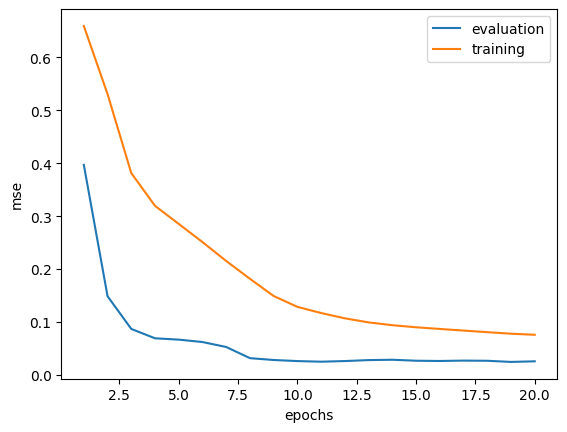

Params of eemd Transformer at epoch 20 Condemned_Squirrel
{'d_ff': 1024,
 'd_model': 256,
 'dropout': 0.2,
 'num_heads': 2,
 'num_layers': 2,
 'src_seq_length': 24,
 'src_size': 5,
 'src_window': 8,
 'tgt_seq_length': 3,
 'tgt_size': 5,
 'tgt_window': 8}


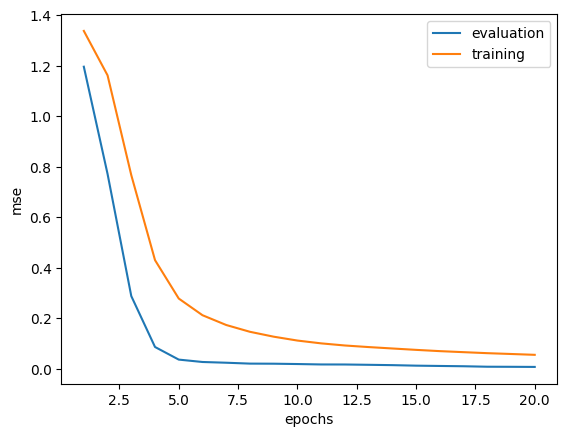

In [26]:
def print_params(test: str, name: str, epoch: int, model_type: type, params: dict):
    print(f'Params of {test} {model_type.__name__} at epoch {epoch} {name}')
    pprint.pprint(params)

def plot_metrics(metrics: dict):
    plt.plot(np.arange(1, len(metrics['train']['MSE']) + 1), metrics['eval']['MSE'], label=f'evaluation')
    plt.plot(np.arange(1, len(metrics['train']['MSE']) + 1), metrics['train']['MSE'], label=f'training')
    plt.xlabel('epochs')
    plt.ylabel('mse')
    plt.legend()
    plt.show()

for load_param, model in zip(load_params, trained):
    print_params(**load_param, params=model['params'])
    plot_metrics(model['metrics'])

### Show best model

In [27]:
def bold_min(col):
    bold = 'font-weight: bold'
    default = ''
    
    min_in_col = col.min()
    return [bold if v == min_in_col else default for v in col]

d = {'mse': [model['metrics']['eval']['MSE'][-1] for model in trained], 'rmse': [model['metrics']['eval']['RMSE'][-1] for model in trained],
     'mae': [model['metrics']['eval']['MAE'][-1] for model in trained], 'mape': [model['metrics']['eval']['MAPE'][-1] for model in trained]}
df = pd.DataFrame(data=d, index=[f'{load_param["test"]} - {load_param["name"]}' for load_param in load_params])
df.style.apply(bold_min, axis=0)

,mse,rmse,mae,mape
regular - Condemned_Squirrel,0.025853,0.154846,0.117628,0.039643
eemd - Condemned_Squirrel,0.006886,0.081203,0.054179,0.005616


## Testing on sample data

### Load sample data

In [28]:
df = data_loader.load_mavir_data('data/mavir_data/mavir.csv')
df['Power'] = utils.min_max_norm(df['Power'])
sample = utils.sample(df, 1000, start_idx=5000)

### Create datasets for models

In [29]:
decomposed = eemd.EEMDWrapper(sample['Power'].to_numpy(), 3)

data = {'regular': np.array(sample['Power'].to_numpy()[..., np.newaxis], dtype=np.float32),
        'eemd': np.array(np.concatenate([decomposed.get_imfs().transpose(), decomposed.get_residue()[..., np.newaxis]], dtype=np.float32, axis=1))}

datasets = {}

for load_param, model in zip(load_params, trained):
    datasets[load_param['test']] = TimeSeriesWindowedTensorDataset(data[load_param['test']], 
                                                                   TimeSeriesWindowedDatasetConfig(model['params']['src_window'], 
                                                                   model['params']['tgt_window'], 
                                                                   model['params']['src_seq_length'], 
                                                                   model['params']['tgt_seq_length'], 1, False))


### Run the tests on sample data

Params of regular Transformer at epoch 20 Condemned_Squirrel
{'d_ff': 1024,
 'd_model': 256,
 'dropout': 0.2,
 'num_heads': 2,
 'num_layers': 2,
 'src_seq_length': 24,
 'src_size': 1,
 'src_window': 8,
 'tgt_seq_length': 3,
 'tgt_size': 1,
 'tgt_window': 8}


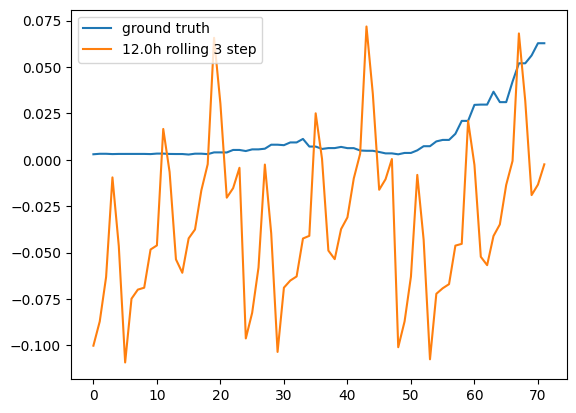

Params of eemd Transformer at epoch 20 Condemned_Squirrel
{'d_ff': 1024,
 'd_model': 256,
 'dropout': 0.2,
 'num_heads': 2,
 'num_layers': 2,
 'src_seq_length': 24,
 'src_size': 5,
 'src_window': 8,
 'tgt_seq_length': 3,
 'tgt_size': 5,
 'tgt_window': 8}


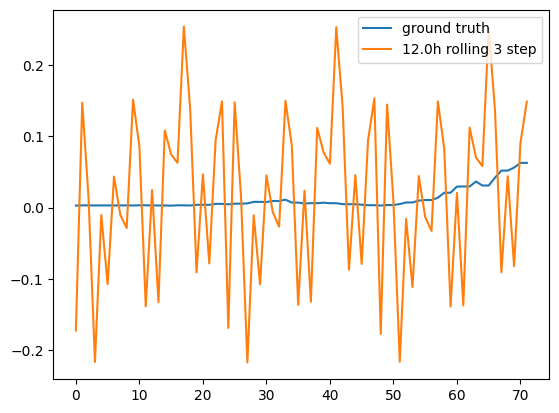

In [41]:
shift, look_back, pred, rolling = 250, 24, 3, 72

def predict_with_model(prediction_model, dataset, post_processor):
    ones = torch.ones(1, 1, dataset[0][1].shape[-1])

    with torch.no_grad():
        gt = []
        p = []
        for shift_offset in range(shift, shift+rolling, pred*dataset.ws_y):
            out = ones
            for i in range(pred):
                out = torch.concatenate((ones, prediction_model(dataset[shift_offset][0].unsqueeze(0), out)), dim=1)
        
            p.append(post_processor(dataset.get_sequence_from_y_windows(out[:, 1:, :].detach())))
            gt.append(post_processor(dataset.get_sequence_from_y_windows(dataset[shift_offset][1])))
        
    return gt, p


for load_param, model, post in zip(load_params, trained, post_processors):
    print_params(**load_param, params=model['params'])
    ground_truth, predicted = predict_with_model(model['model'], datasets[load_param['test']], post)
    predicted = np.array(predicted).reshape(rolling)
    ground_truth = np.array(ground_truth).reshape(rolling)
    
    plt.plot(ground_truth, label='ground truth')
    plt.plot(predicted, label=f'{rolling*10/60}h rolling {pred} step')            
    plt.legend()
    plt.show()